# 0 Utils

In [41]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
# sb.set()
import matplotlib.pyplot as plt
import pandas as pd
import shap
import copy


In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
N_JOBS = 6 # -1 ocupa todo los cores
RANDOM_STATE = 42 # para que sea reproducible

In [44]:
folder_results = 'resultados_compra\\'

## Experiment Setting 

In [45]:
import time
start_time = time.time()


In [46]:
# dataset, base nro 2
dataset_nro = 8
experiment_nro = 1
# 'All Proyects', 'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
proyecto_select = 'San Andres Del Valle' #cambiable

# base, base_profesion, base_minusisprofesion, base_medini_isrec
use_predictors = 'no_is_time_price' #cambiable
# experimento 2 y 4 va con True
no_nulls = False #cambiable
sesgo = False #cambiable

In [47]:
predictors_set = dict()

no_is_time_price = [
    'is_recontacto', 'is_remoto', 'is_descuento', 'valid_rut',
    'loc_comuna', 'loc_provincia', 'loc_region', 'sexo', 'tipo_cliente',
    'mean_cot_bod',
    'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial',
    'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta',
    'nro_cot_estu', 'nro_proyectos', 'precio_cotizacion_media',
    'precio_cotizacion_median', 'precio_cotizacion_std', 
    
    'tiempo_cotizacion_media', 'tiempo_cotizacion_median',
    'tiempo_cotizacion_std',   
    'Altos del Valle',
    'Edificio Urban 1470', 
#     'San Andres Del Valle', 
    'Edificio Mil610',
       'Edificio Junge']
predictors_set ['no_is_time_price'] = no_is_time_price


# 1 Load Dataset

In [48]:
# nombre experimento
exp_name = "{} {}".format(proyecto_select, use_predictors)
# eleccion dataset
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

directory = '..\\results\\test_model_results_dataset{}'.format(dataset_nro)
import os
if not os.path.exists(directory):
    os.makedirs(directory)

folder = '..\\results\\model_results_dataset{}\\{}'.format(dataset_nro, DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")

readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

# print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6155, 47)


In [49]:
personas['loc_comuna'] = personas['loc_comuna'].astype('category')
personas['loc_provincia'] = personas['loc_provincia'].astype('category')
personas['loc_region'] = personas['loc_region'].astype('category')
personas['tipo_cliente'] = personas['tipo_cliente'].astype('category')
personas['sexo'] = personas['sexo'].astype('category')
# personas.profesion.fillna('sin informacion', inplace=True)
# personas['profesion'] = personas['profesion'].astype('category')
personas['medio_inicial'] = personas['medio_inicial'].astype('category')

In [50]:
personas_original = copy.deepcopy(personas)

In [51]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
if proyecto_select != 'All Proyects':
    mask = (personas[proyecto_select] > 0)
    personas = personas[mask]
    print(personas[mask].shape)
    personas[mask]
###########################################################

predictors = predictors_set[use_predictors]

if no_nulls:
    personas.replace(['sin informacion'], np.nan, inplace=True)
    personas.dropna(inplace=True)

(3799, 47)


Class 0: 3564
Class 1: 235
Proportion: 15.17 : 1


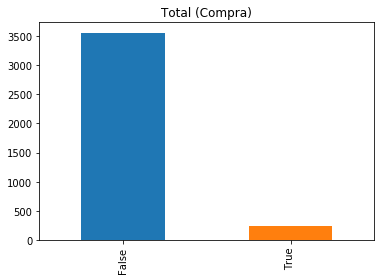

In [52]:
#OVER SAMPLING

predictors = predictors_set[use_predictors]
p_i = personas.copy(deep=True)
p_i = p_i[p_i['San Andres Del Valle'] > 0]

target_count = p_i.compra.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# plt
target_count.plot(kind='bar', title='Total (Compra)');
plt.savefig('resultados_compra\\total_compra_etiquetas.png', dpi=300)

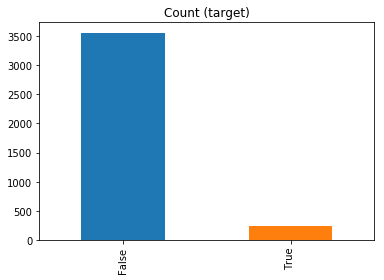

In [53]:
y = p_i.compra
p_i = p_i[predictors]
X = pd.get_dummies(p_i)
col_predictors = X.columns

df = copy.deepcopy(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [54]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

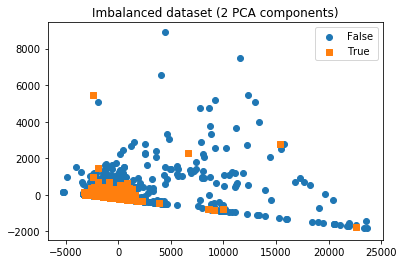

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_plot = pca.fit_transform(X)

plot_2d_space(X_plot, y, 'Imbalanced dataset (2 PCA components)')

In [56]:
# print(predictors)
# Ready Data Set
# p_negocio = personas.negocio # Target
p_negocio = personas.compra # Target
p_negocio = pd.Series([1 if x == True else -1 for x in p_negocio.tolist()])
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)

readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

(3799,)
(3799, 29)
(3799, 29)


# 3 Supervised Learning: Classification

## 3.1 Libraries

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn import svm
from xgboost import XGBClassifier

import itertools

from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## 3.2 Check the Dataset

In [58]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == -1].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == -1].shape

Tamaño Total:  (3799, 55)
Personas que hicieron Negocio:  (235,)
Personas que no Hicieorn Negocio:  (3564,)


## 3.4 Help Functions

In [59]:
import scikitplot as skplt

def classifier_insights(y_test, clf_probas, model_name, model, f_importance = False):
    
    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_cumulative_gain(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
#     plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_cum_gain.png'.format(dataset_nro, DS_NAME, model_name), bbox_inches = 'tight', dpi=300)
    plt.show()


    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_lift_curve(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
#     plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_lift.png'.format(dataset_nro, DS_NAME, model_name), bbox_inches = 'tight', dpi=300)
    plt.show()
    
    if f_importance:
        fig = plt.figure()
        ax = plt.subplot(skplt.estimators.plot_feature_importances(
            model, feature_names=col_predictors, x_tick_rotation=90, figsize=(12,8)))
        plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
#         plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_f_importance.png'.format(dataset_nro, DS_NAME, model_name), bbox_inches = 'tight', dpi=300)
        plt.show()

    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_precision_recall(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
#     plt.savefig('..//results/model_results_dataset{}\\{}\\{}_precition_recall.png'.format(dataset_nro, DS_NAME, model_name), bbox_inches = 'tight', dpi=300)
    plt.show()

    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_ks_statistic(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
#     plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_ks_sta.png'.format(dataset_nro, DS_NAME, model_name), bbox_inches = 'tight', dpi=300)
    plt.show()

In [60]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results_dataset{}\\{}\\readme_{}.txt'.format(dataset_nro, DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

def plot_all_auc_values():
        
    d = dict()
    for key in roc_curves_to_plot[DS_NAME]:
        d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
    x_model = [x[0] for x in s]
    x_value = [x[1] for x in s]
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    f = plt.figure(figsize=(12,8))
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, x_value)
    plt.xticks(x, x_model)
#     plt.savefig('..\\results\\model_results_dataset{}\\{}\\auc_models.png'.format(dataset_nro, DS_NAME,DS_NAME), dpi=300)
    plt.show()

def plot_all_roc_curves():
    
    f = plt.figure(figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['random choice']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
#     plt.savefig('..\\results\\model_results_dataset{}\\{}\\roc_curve_all.png'.format(dataset_nro, DS_NAME, MODEL), dpi=300)
    plt.show()

In [61]:
# SAVE RESULTS
from sklearn.externals import joblib
import copy 
import json

# results_copy = copy.deepcopy(clfs_results)

def save_results(results, file_name='grid_results'):
    for clf in results_copy.keys():
        folder = 'models_persistance\\{}\\'.format(clf)

        if not os.path.exists(folder):
            os.mkdir(folder)

        for cv in results_copy[clf].keys():
            to_save = results_copy[clf][cv]['grid_best_model']
            joblib.dump(to_save,'{}{}_compra_model.joblib'.format(folder, clf))
            results_copy[clf][cv]['grid_best_model'] = ''
            results_copy[clf][cv]['grid_std'] = results_copy[clf][cv]['grid_std'].tolist()
            pd.DataFrame(results_copy[clf][cv]['grid_cvresults']).to_excel('{}{}_{}_grid_compra.xlsx'.format(folder, clf, cv))
            results_copy[clf][cv]['grid_cvresults'] = ''
            results_copy[clf][cv]['best_model_test_ypred'] = results_copy[clf][cv]['best_model_test_ypred'].tolist()


    with open('{}.json'.format(file_name), 'w') as fp:
        json.dump(results_copy, fp)

In [62]:
color_sequence = ['#f44242', '#f4eb41', '#acf441', '#285919', '#41f4eb',
                  '#4146f4', '#7041f4', '#593518', '#f441f1', '#f44173']

def battle_roc(clf, dr):
    f = plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    rank= 0
    legends = ['random choice']
    for cv, value in dr[clf].items():
        model =dr[clf][cv]['best_model']
        model.fit(X_grid,y_grid)
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, treshold = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        legends.append('cv %i %.4f' %(cv, roc_auc))
        plt.plot(fpr, tpr, color=color_sequence[rank]) #fpr and tpr
        rank +=1
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
#     plt.savefig('..\\results\\model_results_dataset{}\\{}\\{}_battle_roc_curve.png'.format(dataset_nro, DS_NAME, clf), dpi=300)
    plt.show()

In [63]:
def battle_cv(clf, results):
    data, cv_a, acc, rec, pre, auc, fs = [], [], [], [], [], [], []
    for cv in results[clf].keys():
        r = results[clf][cv]
        cv_a.append(cv);acc.append(r['acc']);rec.append(r['rec']);pre.append(r['pre'])
        auc.append(r['auc']);fs.append(r['fs'])
    metrics = [acc,rec,pre,auc,fs]
    metrics_name = ['acc','rec','pre','auc','fs']
    for i in range(len(metrics)):
        trace = go.Scatter(
            x = cv_a,
            y = metrics[i],
            name= metrics_name[i]
        )
        data.append(trace)
    return data

In [64]:
def view_results(results):
    for clf in results.keys():
        print("Classifier: ", clf)
        for cv in results[clf].keys():
                r = results[clf][cv]
                print(
            'cv: ', i,
            'acc %.4f' % r['acc'],
            '+- %.4f'% r['acc-std'],
            '| pre %.4f'% r['pre'],
            '+- %.4f'% r['pre-std'],
            '| rec %.4f'% r['rec'],
            '+- %.4f'% r['rec-std'],
            '| fs %.4f'% r['fs'],
            '+- %.4f'% r['fs-std'],
            '| auc %.4f'% r['auc'],
            '+- %.4f'% r['auc-std'],
             )

In [65]:
import plotly.plotly as py
import plotly.graph_objs as go
# py.sign_in(api_key='vM02r1sRNCokCK2O04A3', username='jcardenas.lie')
py.sign_in(api_key='GzJkEHgbGPp7aEmHy0BZ', username='japinoza')

def box_plot(results, metric):
    data = []

    for clf in results.keys():
        y = []
        for cv in results[clf].keys():
            y.append(results[clf][cv][metric])
        data.append(go.Box(
            y=y,
            name=clf
        ))
    layout = go.Layout(
        title = "Box Plot {}".format(metric)
    )

    fig = go.Figure(data=data, layout=layout)
    return fig

In [66]:
def battle_conf_matrix(clf, results):
    for cv in results[clf].keys():
        model =results[clf][cv]['best_model']
#         model.set_params(class_weight='balanced')
        model.fit(X_grid,y_grid)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print(tp, tn)
        print(classification_report(y_test, y_pred))
        print('Test: Recall: %.3f' % (tp/(tp+fp)), ' Precision: %.3f' % (tp/(tp+fn)))
        # predict_mine = np.where(y_proba > 0.989, 1, 0)
    #     print(confusion_matrix(y_test, y_pred))
    #     roc_curve_plot(model, X_test, y_test)
        plot_confusion_matrix(y_test, y_pred, ['Negocio', 'No Negocio'], \
                              normalize=True, title='Confusion Matrix {} cv:{}'.format(clf, cv))

In [67]:
def cumulative_gain_curve_m(y_true, y_score, pos_label=None):
    y_true, y_score = np.asarray(y_true), np.asarray(y_score)

    # ensure binary classification if pos_label is not specified
    classes = np.unique(y_true)
    if (pos_label is None and
        not (np.array_equal(classes, [0, 1]) or
             np.array_equal(classes, [-1, 1]) or
             np.array_equal(classes, [0]) or
             np.array_equal(classes, [-1]) or
             np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    sorted_indices = np.argsort(y_score)[::-1]
    y_true = y_true[sorted_indices]
    gains = np.cumsum(y_true)

    percentages = np.arange(start=1, stop=len(y_true) + 1)

    gains = gains / float(np.sum(y_true))
    percentages = percentages / float(len(y_true))

    gains = np.insert(gains, 0, [0])
    percentages = np.insert(percentages, 0, [0])

    return percentages, gains

def plot_lift_curve_m(clf, results, X_test, y_test, threshold = None):
    y_true = y_test
    data = []
    for cv in results[clf].keys():
        r = results[clf][cv]
        
#         model.fit(X_grid, y_grid)
        y_probas = model.predict_proba(X_test)
    
        if threshold:
            y_pred = np.where(predict_probabilities > threshold, 1, 0)

        y_true = np.array(y_true)

        classes = np.unique(y_true)
        if len(classes) != 2:
            raise ValueError('Cannot calculate Lift Curve for data with '
                             '{} category/ies'.format(len(classes)))

        # Compute Cumulative Gain Curves
        percentages, gains2 = cumulative_gain_curve_m(y_true, y_probas[:, 0], classes[0])

        percentages = percentages[1:]
        gains2 = gains2[1:]

        gains2 = gains2 / percentages

        trace1 = go.Scatter(
            x = percentages,
            y = gains2,
            mode = 'lines+markers',
            name = clf
        )
        data.append(trace1)
    
    trace2 = go.Scatter(
        x = [0,1],
        y = [1,1],
        line = dict(
            color = ('rgb(205, 12, 24)'),
            width = 4,
            dash = 'dot'
        ),
        name = 'baseline'
    )
    data.append(trace2)
    
    layout = dict(title = 'Lift Curve',
              xaxis = dict(title = 'Porcentaje de la Muestra (%)'),
              yaxis = dict(title = 'Gain'),
              )
    return {'data':data, 'layout':layout}

In [68]:
def combo_chart(feature, model, data):

    data['1'] = 1
    personas_view = data[data['San Andres Del Valle'] > 0 ]
    data = dict()

    # columna = 'nro_cot_depto'
    columna = feature
    for group, frame in personas_view.groupby(columna):
        data[group] = {}
        data[group]['negocio'] = frame[frame['negocio'] == True]['1'].sum()
        data[group]['no negocio'] = frame[frame['negocio'] == False]['1'].sum()


    to_x, to_neg, to_noneg = [], [], []
    for key in data.keys():
        to_x.append(key)
        to_neg.append(data[key]['negocio'])
        to_noneg.append(data[key]['no negocio'])
    mult = int(len(to_x)/5)


    to_g_name, to_g_neg, to_g_noneg = [], [], []
    for i in range(0,5):
    #     print((mult*i),(mult*(i+1)))
        name = '{} - {}'.format(to_x[mult*i], to_x[mult*(i+1)])
        to_g_name.append(name)
        to_g_neg.append(sum(to_neg[(mult*i):(mult*(i+1))]))
        to_g_noneg.append(sum(to_noneg[(mult*i):(mult*(i+1))]))

    exito = [float("{0:.2f}".format(x/(x+y))) for x, y in zip(to_g_neg, to_g_noneg)]
    # print(to_g_name, to_g_neg, to_g_noneg, exito)

    trace1 = go.Bar(
        x=to_g_name,
        y=to_g_neg,
        name='Negocio',
        marker=dict(
            color='rgb(55, 83, 109)'
        )
    )
    trace2 = go.Bar(
        x=to_g_name,
        y=to_g_noneg,
        name='No Negocio',
        marker=dict(
            color='rgb(26, 118, 255)'
        )
    )

    trace3 = go.Scatter(
        x=to_g_name,
        y=exito,
        yaxis='y2',
        name='% Éxito'
    )
    traces = [trace1, trace2, trace3]

    layout = go.Layout(
        title='Negocio y No Negocio',
        xaxis=dict(
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title='Número Personas',
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis2=dict(
            title='% Éxito',
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            ),
            overlaying='y',
            side='right'
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='stack',
        bargap=0.15,
        bargroupgap=0.5
    )
    figure = go.Figure(data=traces, layout=layout)
    return figure

In [69]:
def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results_dataset{}\\{}\\{}_importance.png'.format(dataset_nro, DS_NAME, MODEL), dpi=300)
    plt.show()

    # Import necessary modules
def plot_confusion_matrix(y, y_pred, classes,
                        normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, folder=''):
    
    cm = confusion_matrix(y, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(folder_results + '{}.png'.format(title), dpi=300)
    plt.show()


def roc_curve_plot(model, X_test, y_test, folder='', title='Model ROC Curve' ):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    matrix = metrics.confusion_matrix(y_true=y_test, y_pred=model.predict(X_test))
    tn, fp, fn, tp = matrix.ravel()
    fpr_point = fp / (fp + tn)
    tpr_point = tp / (tp + fp)
    
    print("AUC: ",roc_auc_score(y_test, y_pred_prob))
    print("Point in ROC", fpr_point,tpr_point)

    # Plot ROC curve
#     plt.plot(fpr_point,tpr_point)
    markers_on = [fpr_point]
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.savefig(folder_results + '{}.png'.format(title), dpi=300)
    plt.show()
    
def grid_results(grid, scorer, plot=False):
    
    best_model = grid.best_estimator_
    
    grid_results = pd.DataFrame(grid.cv_results_)[['mean_train_accuracy',
       'mean_train_auc', 'mean_train_f1_score', 'mean_train_precision',
       'mean_train_recall','mean_test_accuracy',
       'mean_test_auc', 'mean_test_f1_score', 'mean_test_precision',
       'mean_test_recall','std_test_accuracy', 'std_test_auc', 'std_test_f1_score',
       'std_test_precision', 'std_test_recall',
        'std_train_accuracy', 'std_train_auc', 'std_train_f1_score',
       'std_train_precision', 'std_train_recall','rank_test_accuracy', 'rank_test_auc', 'rank_test_f1_score',
       'rank_test_precision', 'rank_test_recall', 'params']]
    grid_results = grid_results.sort_values(by='rank_test_{}'.format(scorer))
    
    matrix = metrics.confusion_matrix(y_true=y_test, y_pred=best_model.predict(X_test))
    tn, fp, fn, tp = matrix.ravel()
    
    print('Validation set:')
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)
    a = (tp + tn) / (tn + fp + fn + tp)
    p = tp /(tp + fn)
    r = tp / (tp + fp)
    f = (2* p* r) / (p + r)
    auc = roc_auc_score(y_test, best_model.predict(X_test) )
    print('tpr: %.3f' % r, 'fpr %.3f' % (fp /(fp + tn)), 'auc %.2f '%auc)
    print('a: %.3f' % a, 'p %.3f' % p, 'r %.3f' % r, 'f %.3f'% f )
    print('TN %.2f'%(tn/(tn+fp)), 'TP %.2f'% p)
    
    return {
        'ts_acc':grid_results.loc[0,'mean_test_accuracy'],
        'ts_acc-std':grid_results.loc[0,'std_test_accuracy'],
        'ts_pre':grid_results.loc[0,'mean_test_precision'],
        'ts_pre-std':grid_results.loc[0,'std_test_precision'],
        'ts_rec':grid_results.loc[0,'mean_test_recall'],
        'ts_rec-std':grid_results.loc[0,'std_test_recall'],
        'ts_fs':grid_results.loc[0,'mean_test_f1_score'],
        'ts_fs-std':grid_results.loc[0,'std_test_f1_score'],
        'ts_auc':grid_results.loc[0,'mean_test_auc'],
        'ts_auc-std':grid_results.loc[0,'std_test_auc'],
        'tr_acc':grid_results.loc[0,'mean_train_accuracy'],
        'tr_acc-std':grid_results.loc[0,'std_train_accuracy'],
        'tr_pre':grid_results.loc[0,'mean_train_precision'],
        'tr_pre-std':grid_results.loc[0,'std_train_precision'],
        'tr_rec':grid_results.loc[0,'mean_train_recall'],
        'tr_rec-std':grid_results.loc[0,'std_train_recall'],
        'tr_fs':grid_results.loc[0,'mean_train_f1_score'],
        'tr_fs-std':grid_results.loc[0,'std_train_f1_score'],
        'tr_auc':grid_results.loc[0,'mean_test_auc'],
        'tr_auc-std':grid_results.loc[0,'std_test_auc'],
        'best_model': grid.best_estimator_,
        'grid_cvresults': grid.cv_results_,
    }

## 3.3 Train & Test

In [70]:
X = personas 
y = p_negocio

X_grid, X_test, y_grid, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_grid.shape, X_test.shape, y_grid.shape, y_test.shape)


# X_test.to_excel('x_test.xlsx')
# y_test.to_excel('y_test.xlsx')

(3039, 55) (760, 55) (3039,) (760,)


## 3.5 Models

In [71]:
clfs = dict()
clfs['LR'] = LogisticRegression(random_state=RANDOM_STATE)
clfs['DT'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
clfs['RF'] = RandomForestClassifier(random_state=RANDOM_STATE)
# clfs['SVM'] = svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
clfs['KNN'] = KNeighborsClassifier()
clfs['PCAKNN'] = Pipeline([('pca', PCA(random_state=RANDOM_STATE)), ('clf', KNeighborsClassifier())])
clfs['XGB'] = XGBClassifier(random_state=RANDOM_STATE)

In [72]:
# clfs = dict()
# clfs['DT'] = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# clfs['LR'] = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# clfs['RF'] = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# # clfs['SVM'] = svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
# clfs['KNN'] = KNeighborsClassifier()
# clfs['PCAKNN'] = Pipeline([('pca', PCA(random_state=RANDOM_STATE)), ('clf', KNeighborsClassifier())])
# clfs['XGB'] = XGBClassifier(random_state=RANDOM_STATE)

In [73]:
clf_params = dict()
clf_params['KNN'] = {'n_neighbors': np.arange(1, 20)}
clf_params['PCAKNN'] = {'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9]}
clf_params['LR'] = {'C': np.logspace(-5, 8, 15), 'penalty':['l1', 'l2'], 'class_weight':[None, 'balanced']}
clf_params['DT'] = {"max_depth": range(1,20),"max_features":range(1,30), 
                    "min_samples_leaf": range(1,10),"criterion": ["gini", "entropy"], 
                    'class_weight':[None, 'balanced']}
clf_params['RF'] = {"max_depth": range(1,20),"max_features":range(1,30), "min_samples_leaf": range(1,10),
                    "criterion": ["gini", "entropy"], 'class_weight':[None, 'balanced']}
#SVM PARAMS
# clf_params['SVM'] = {'C' :[0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1], 'class_weight':[None, 'balanced']}
# XGB PARAMS
clf_params['XGB'] = {'n_estimators' : [50, 100, 150, 200], 'max_depth' : [2, 4, 6, 8]}

In [74]:
# clf_params = dict()
# clf_params['KNN'] = {'n_neighbors': np.arange(1, 20)}
# clf_params['PCAKNN'] = {'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9]}
# clf_params['LR'] = {'C': np.logspace(-5, 8, 15), 'penalty':['l1', 'l2']}
# clf_params['DT'] = {"max_depth": range(1,20),"max_features":range(1,30), 
#                     "min_samples_leaf": range(1,10),"criterion": ["gini", "entropy"],}
# clf_params['RF'] = {"max_depth": range(1,20),"max_features":range(1,30), "min_samples_leaf": range(1,10),
#                     "criterion": ["gini", "entropy"]}
# #SVM PARAMS
# # clf_params['SVM'] = {'C' :[0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1], 'class_weight':[None, 'balanced']}
# # XGB PARAMS
# clf_params['XGB'] = {'n_estimators' : [50, 100, 150, 200], 'max_depth' : [2, 4, 6, 8]}

In [75]:
clfs_results = dict()
clfs_results['LR'] = dict()
clfs_results['DT'] = dict()
clfs_results['RF'] = dict()
clfs_results['PCAKNN'] = dict()
clfs_results['KNN'] = dict()
clfs_results['XGB'] = dict()
# clfs_results['SVM'] = dict()


In [76]:
def view_grid(r):
    print(
            'cv: ', i, '\n', 'Test'
            ' acc %.4f' % r['ts_acc'],
            '+- %.4f'% r['ts_acc-std'],
            '| pre %.4f'% r['ts_pre'],
            '+- %.4f'% r['ts_pre-std'],
            '| rec %.4f'% r['ts_rec'],
            '+- %.4f'% r['ts_rec-std'],
            '| fs %.4f'% r['ts_fs'],
            '+- %.4f'% r['ts_fs-std'],
            '| auc %.4f'% r['ts_auc'],
            '+- %.4f'% r['ts_auc-std'],
            '\n','Train',
            'acc %.4f' % r['tr_acc'],
            '+- %.4f'% r['tr_acc-std'],
            '| pre %.4f'% r['tr_pre'],
            '+- %.4f'% r['tr_pre-std'],
            '| rec %.4f'% r['tr_rec'],
            '+- %.4f'% r['tr_rec-std'],
            '| fs %.4f'% r['tr_fs'],
            '+- %.4f'% r['tr_fs-std'],
            '| auc %.4f'% r['tr_auc'],
            '+- %.4f'% r['tr_auc-std'],
            '\n'
        )

# Grid

In [77]:

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
          'auc':make_scorer(roc_auc_score)}

for clf in clfs.keys():
    scorer = 'f1_score'
    print("Classifier:",clf, ' Scorer:', scorer)
    for i in range(2,3):

        kf = StratifiedKFold(n_splits=i, shuffle=True, random_state=RANDOM_STATE)

        if clf == 'RF' or clf == 'DT':
            grid = RandomizedSearchCV(clfs[clf], clf_params[clf], \
                                      cv=kf, n_jobs=N_JOBS, n_iter=300, \
                                      random_state=RANDOM_STATE, scoring=scoring, refit=scorer)
        else:
            grid = GridSearchCV(clfs[clf], clf_params[clf], cv=kf, n_jobs=N_JOBS\
                                , scoring=scoring, refit=scorer)
        
        grid.fit(X_grid, y_grid)

        clfs_results[clf][i] = grid_results(grid, scorer)
        r = clfs_results[clf][i]
        print(
            'cv: ', i, '\n', 'Test'
            ' acc %.4f' % r['ts_acc'],
            '+- %.4f'% r['ts_acc-std'],
            '| pre %.4f'% r['ts_pre'],
            '+- %.4f'% r['ts_pre-std'],
            '| rec %.4f'% r['ts_rec'],
            '+- %.4f'% r['ts_rec-std'],
            '| fs %.4f'% r['ts_fs'],
            '+- %.4f'% r['ts_fs-std'],
            '| auc %.4f'% r['ts_auc'],
            '+- %.4f'% r['ts_auc-std'],
            '\n','Train',
            'acc %.4f' % r['tr_acc'],
            '+- %.4f'% r['tr_acc-std'],
            '| pre %.4f'% r['tr_pre'],
            '+- %.4f'% r['tr_pre-std'],
            '| rec %.4f'% r['tr_rec'],
            '+- %.4f'% r['tr_rec-std'],
            '| fs %.4f'% r['tr_fs'],
            '+- %.4f'% r['tr_fs-std'],
            '| auc %.4f'% r['tr_auc'],
            '+- %.4f'% r['tr_auc-std'],
            '\n'
             )
    print('\n')
    

Classifier: LR  Scorer: f1_score
Validation set:
tn 584 fp 143 fn 6 tp 27
tpr: 0.159 fpr 0.197 auc 0.81 
a: 0.804 p 0.818 r 0.159 f 0.266
TN 0.80 TP 0.82
cv:  2 
 Test acc 0.9335 +- 0.0000 | pre 0.0000 +- 0.0000 | rec 0.0000 +- 0.0000 | fs 0.0000 +- 0.0000 | auc 0.5000 +- 0.0000 
 Train acc 0.9335 +- 0.0000 | pre 0.0000 +- 0.0000 | rec 0.0000 +- 0.0000 | fs 0.0000 +- 0.0000 | auc 0.5000 +- 0.0000 



Classifier: DT  Scorer: f1_score
Validation set:
tn 446 fp 281 fn 6 tp 27
tpr: 0.088 fpr 0.387 auc 0.72 
a: 0.622 p 0.818 r 0.088 f 0.158
TN 0.61 TP 0.82
cv:  2 
 Test acc 0.7203 +- 0.0644 | pre 0.1557 +- 0.0338 | rec 0.6782 +- 0.0050 | fs 0.2516 +- 0.0452 | auc 0.7008 +- 0.0368 
 Train acc 0.7479 +- 0.0363 | pre 0.1882 +- 0.0245 | rec 0.8218 +- 0.0099 | fs 0.3056 +- 0.0331 | auc 0.7008 +- 0.0368 



Classifier: RF  Scorer: f1_score
Validation set:
tn 643 fp 84 fn 16 tp 17
tpr: 0.168 fpr 0.116 auc 0.70 
a: 0.868 p 0.515 r 0.168 f 0.254
TN 0.88 TP 0.52
cv:  2 
 Test acc 0.8226 +- 0.0240 | p

# ANALYSIS: COMPARE MODELS

In [72]:
# fig = box_plot(clfs_results ,'acc')
# py.iplot(fig)

In [73]:
# fig = box_plot(clfs_results ,'rec')
# py.iplot(fig)

In [74]:
# fig = box_plot(clfs_results ,'pre')
# py.iplot(fig)

In [75]:
# fig = box_plot(clfs_results ,'fs')
# py.iplot(fig)

In [76]:
# fig = box_plot(clfs_results ,'auc')
# py.iplot(fig)

In [ ]:
# RESULTADO Random Forest FUE EL MEJOR

# ANALYSIS: BEST MODEL

In [41]:
data = battle_cv(model_name, clfs_results)
py.iplot(data, filename='basic-line')

KeyError: 'acc'

In [104]:
model_name = 'RF'

107 515
             precision    recall  f1-score   support

         -1       0.91      0.86      0.88       599
          1       0.56      0.66      0.61       161

avg / total       0.83      0.82      0.82       760

Test: Recall: 0.560  Precision: 0.665
Normalized confusion matrix


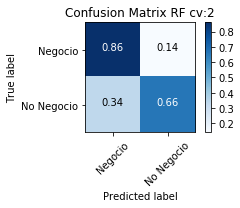

In [110]:
battle_conf_matrix(model_name, clfs_results)

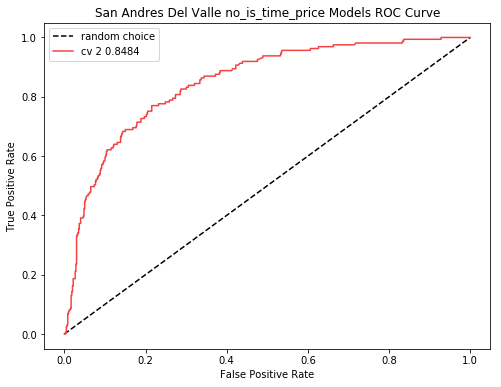

In [134]:
battle_roc(model_name, clfs_results)

# ANALYSIS: BEST CV

In [121]:
cv = 2

In [122]:
model_name = 'RF'

In [139]:
model =clfs_results[model_name][cv]['best_model']
# model.fit(X_grid,y_grid)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# predict_mine = np.where(y_proba > 0.989, 1, 0)
print(classification_report(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))
roc_curve_plot(model, X_test, y_test,  title='Val {} ROC Curve cv{}'.format(model_name, cv))
plot_confusion_matrix(y_test, y_pred, ['No Negocio', 'Negocio'] ,  title='Val {} Confusion Matrix cv{}'.format(model_name, cv), normalize=True)

             precision    recall  f1-score   support

         -1       0.91      0.86      0.88       599
          1       0.56      0.66      0.61       161

avg / total       0.83      0.82      0.82       760

[[515  84]
 [ 54 107]]
AUC:  0.8484119495224961
Point in ROC 0.14023372287145242 0.5602094240837696


ValueError: `markevery` is iterable but not a valid form of numpy fancy indexing; markevery=[0.14023372287145242]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000028257896598> (for post_execute):


ValueError: `markevery` is iterable but not a valid form of numpy fancy indexing; markevery=[0.14023372287145242]

ValueError: `markevery` is iterable but not a valid form of numpy fancy indexing; markevery=[0.14023372287145242]

In [83]:
data = plot_lift_curve_m(model_name, clfs_results, X_test, y_test)
py.iplot(data, filename='basic-line')

(760, 55) (760,) (760,)


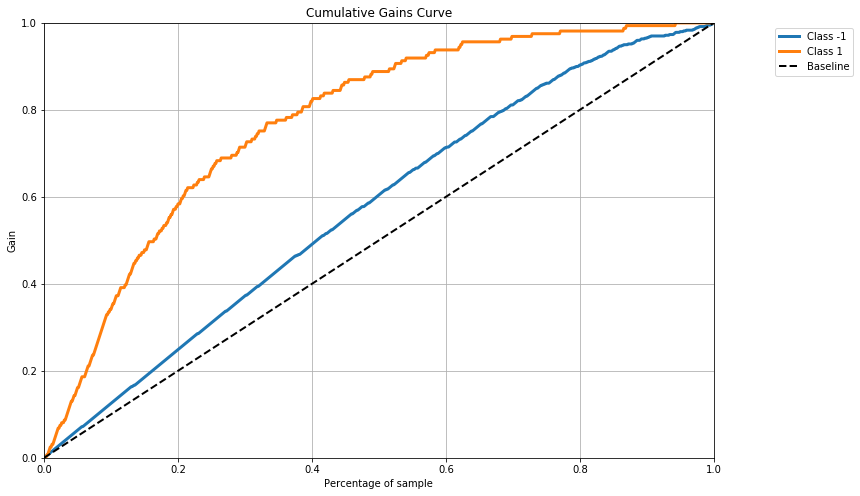

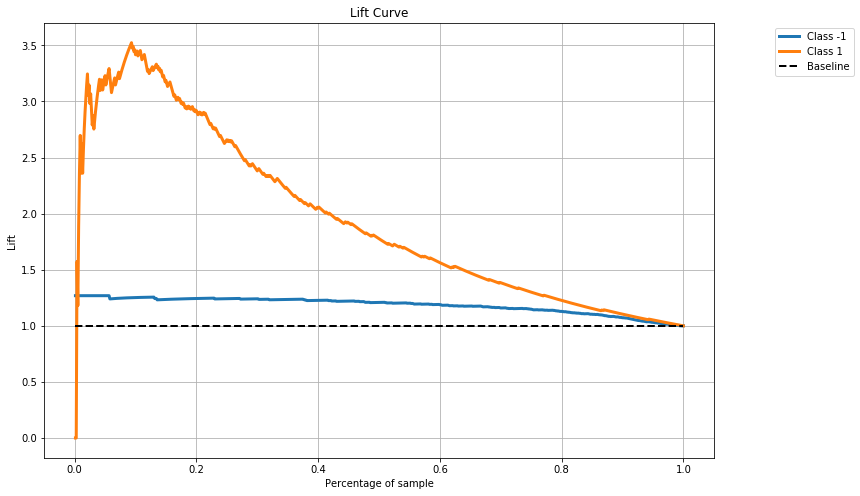

No handles with labels found to put in legend.


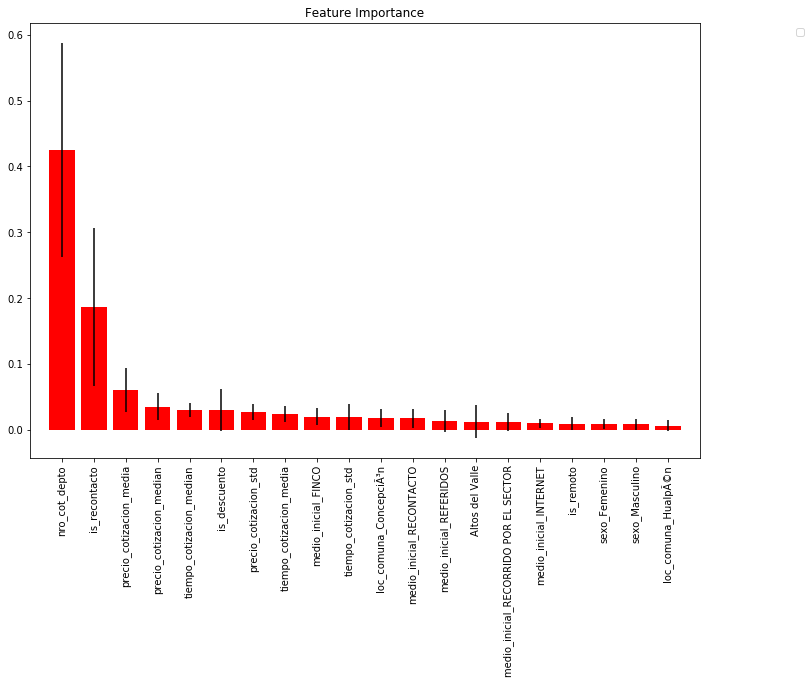

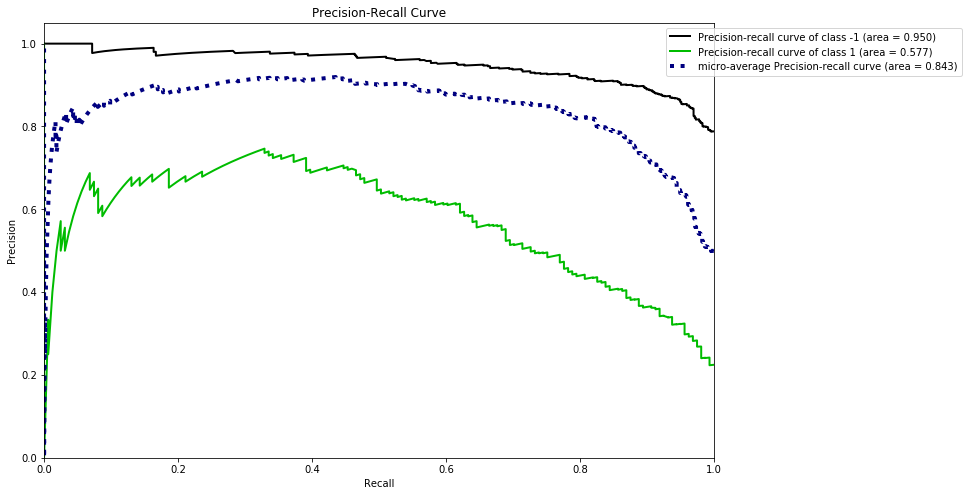

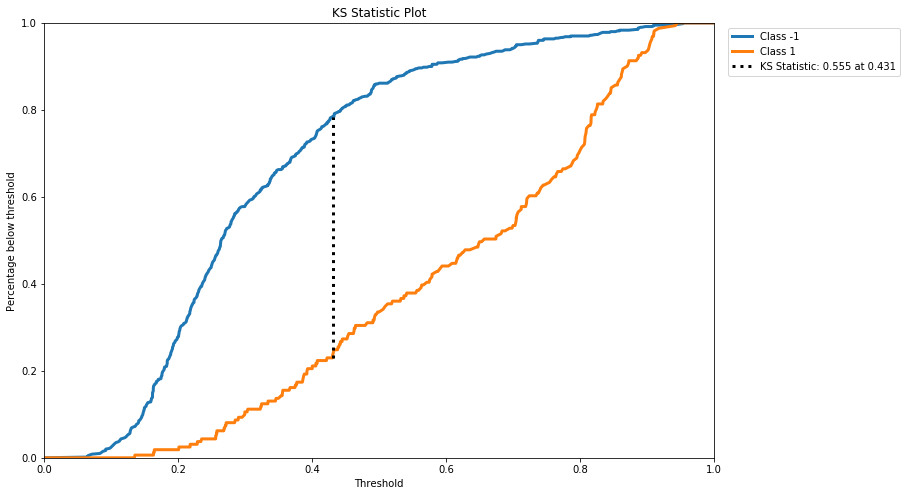

In [84]:
model = clfs_results[model_name][cv]['best_model']
y_pred = model.predict(X_test)
y_probas = model.predict_proba(X_test)

print(X_test.shape, y_test.shape, y_proba.shape)
classifier_insights(y_test, y_probas, model_name, model, f_importance = True)


# ANALYSIS: DESCRIBE ATRIBUTES

In [ ]:
data = combo_chart('nro_cot_depto', model, personas_original)
py.iplot(data, filename='basic-line')

In [39]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def cross_roc_validation(model, X_cros, y_cros,X_val, y_val, splits=3):
    
    kf = StratifiedKFold(n_splits=splits)
    classifier = model

    tprs = []
    aucs, accs, pres, recs, fs = [], [], [], [],[]
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    X_val, y_val = X_val, y_val
    for train, test in kf.split(X_cros, y_cros):
        X_train, y_train, X_test, y_test  = X_cros.iloc[train], y_cros.iloc[train], X_cros.iloc[test], y_cros.iloc[test]
        
        probas_ = classifier.fit(X_train,y_train ).predict_proba(X_test)
        y_pred=classifier.predict(X_test)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
        tn, fp, fn, tp = matrix.ravel()

        a = (tp + tn) / (tn + fp + fn + tp)
        p = tp /(tp + fn)
        r = tp / (tp + fp)
        f = (2* p* r) / (p + r)
        accs.append(a); pres.append(p); recs.append(r); fs.append(f)
        auc_score = roc_auc_score(y_test, classifier.predict(X_test))


        i += 1
    
    print('Test ','\n'
        "acc %.3f +- %.3f"%(np.mean(accs),np.std(accs)),\
          "pre %.3f +- %.3f"%(np.mean(pres),np.std(pres)), \
          "rec %.3f +- %.3f"%(np.mean(recs),np.std(recs)),\
          "fs %.3f +- %.3f"%(np.mean(fs),np.std(fs)),\
          "auc %.3f +- %.3f"%(np.mean(aucs),np.std(aucs)),)
    
    y_val_probas = classifier.fit(X, y).predict_proba(X_val)
    y_val_pred=classifier.predict(X_val)
    
    matrix = metrics.confusion_matrix(y_true=y_val, y_pred=y_val_pred)
    tn, fp, fn, tp = matrix.ravel()

    print('Validation set:')
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)
    a = (tp + tn) / (tn + fp + fn + tp)
    p = tp /(tp + fn)
    r = tp / (tp + fp)
    f = (2* p* r) / (p + r)
    print('tpr: %.3f' % r, 'fpr %.3f' % (fp /(fp + tn)), 'auc %.2f '%auc_score)
    print('a: %.3f' % a, 'p %.3f' % p, 'r %.3f' % r, 'f %.3f'% f )
    print('TN %.2f'%(tn/(tn+fp)), 'TP %.2f'% p)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right",  bbox_to_anchor=(1.7, 0))
    plt.show()

Automatically created module for IPython interactive environment


Classifier  LR
Test  
acc 0.787 +- 0.016 pre 0.676 +- 0.035 rec 0.514 +- 0.026 fs 0.584 +- 0.025 auc 0.826 +- 0.014
Validation set:
tn 496 fp 103 fn 48 tp 113
tpr: 0.523 fpr 0.172 auc 0.74 
a: 0.801 p 0.702 r 0.523 f 0.599
TN 0.83 TP 0.70


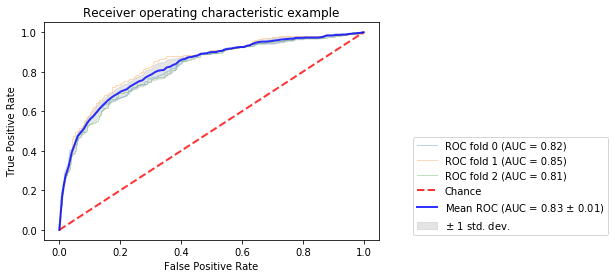

Classifier  DT
Test  
acc 0.729 +- 0.015 pre 0.755 +- 0.039 rec 0.435 +- 0.017 fs 0.552 +- 0.012 auc 0.789 +- 0.018
Validation set:
tn 499 fp 100 fn 60 tp 101
tpr: 0.502 fpr 0.167 auc 0.73 
a: 0.789 p 0.627 r 0.502 f 0.558
TN 0.83 TP 0.63


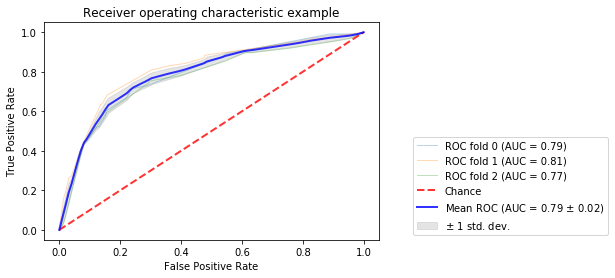

Classifier  RF
Test  
acc 0.798 +- 0.011 pre 0.609 +- 0.018 rec 0.537 +- 0.022 fs 0.570 +- 0.017 auc 0.810 +- 0.015
Validation set:
tn 506 fp 93 fn 38 tp 123
tpr: 0.569 fpr 0.155 auc 0.72 
a: 0.828 p 0.764 r 0.569 f 0.653
TN 0.84 TP 0.76


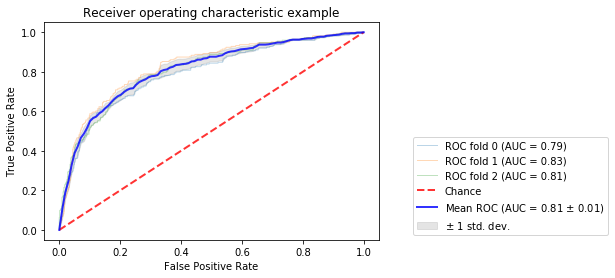

Classifier  PCAKNN
Test  
acc 0.738 +- 0.009 pre 0.078 +- 0.009 rec 0.228 +- 0.038 fs 0.116 +- 0.015 auc 0.531 +- 0.013
Validation set:
tn 589 fp 10 fn 113 tp 48
tpr: 0.828 fpr 0.017 auc 0.49 
a: 0.838 p 0.298 r 0.828 f 0.438
TN 0.98 TP 0.30


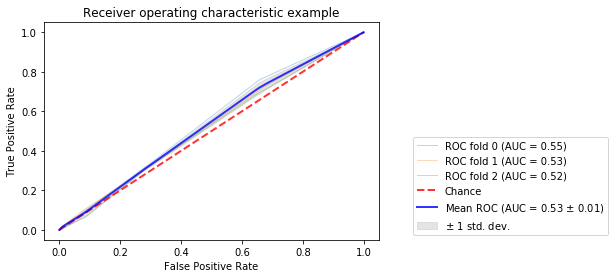

Classifier  KNN
Test  
acc 0.690 +- 0.015 pre 0.243 +- 0.009 rec 0.274 +- 0.017 fs 0.257 +- 0.003 auc 0.530 +- 0.007
Validation set:
tn 599 fp 0 fn 0 tp 161
tpr: 1.000 fpr 0.000 auc 0.54 
a: 1.000 p 1.000 r 1.000 f 1.000
TN 1.00 TP 1.00


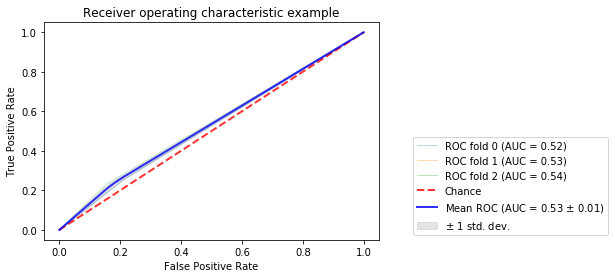

Classifier  XGB
Test  
acc 0.824 +- 0.008 pre 0.437 +- 0.017 rec 0.650 +- 0.030 fs 0.523 +- 0.020 auc 0.808 +- 0.012
Validation set:
tn 595 fp 4 fn 45 tp 116
tpr: 0.967 fpr 0.007 auc 0.70 
a: 0.936 p 0.720 r 0.967 f 0.826
TN 0.99 TP 0.72


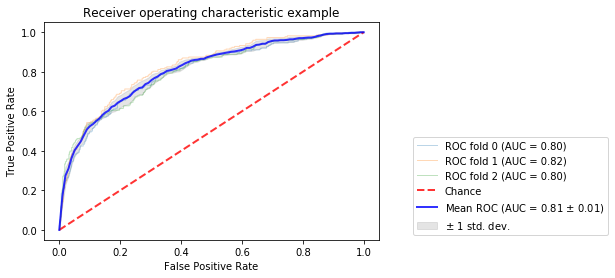

In [40]:
for key in clfs_results.keys():
    print("Classifier ", key)
    model =clfs_results[key][2]['best_model']
    cross_roc_validation(model, X_grid, y_grid, X_test, y_test, splits=3)

             precision    recall  f1-score   support

         -1       0.93      0.84      0.89       599
          1       0.57      0.76      0.65       161

avg / total       0.85      0.83      0.84       760

[[506  93]
 [ 38 123]]
AUC:  0.8944203071371541
Point in ROC 0.15525876460767946 0.5694444444444444


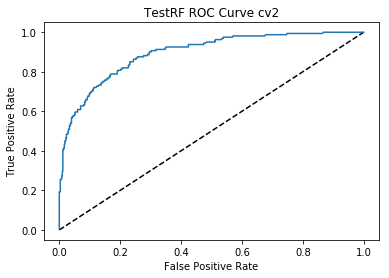

Normalized confusion matrix


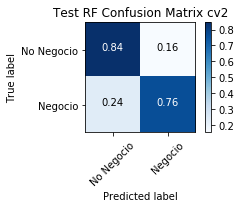

In [338]:
model_name = 'RF'
model =clfs_results[model_name][2]['best_model']
# model.fit(X_grid,y_grid)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# predict_mine = np.where(y_proba > 0.989, 1, 0)
print(classification_report(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))
roc_curve_plot(model, X_test, y_test,  title='Test{} ROC Curve cv{}'.format(model_name, 2))
plot_confusion_matrix(y_test, y_pred, ['No Negocio', 'Negocio'] ,  \
                      title='Test {} Confusion Matrix cv{}'.format(model_name, 2), normalize=True)